In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud, STOPWORDS
import datetime, nltk, warnings

import warnings
warnings.filterwarnings('ignore')

color = sns.color_palette()
%matplotlib inline

In [2]:
df=pd.read_csv('data.csv',low_memory=False)

In [3]:
df.head(10)
# print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591909 entries, 0 to 591908
Data columns (total 8 columns):
InvoiceNo      591909 non-null object
StockCode      591909 non-null object
Description    590455 non-null object
Quantity       591909 non-null int64
InvoiceDate    591909 non-null object
UnitPrice      591909 non-null object
CustomerID     456829 non-null float64
Country        591909 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 36.1+ MB


In [5]:
#dropping null values of customerID
df=df.dropna()

In [6]:
# convert customerID to int and UnitPrice to float
df['CustomerID']=df['CustomerID'].astype('int64')

In [7]:
df['UnitPrice']=pd.to_numeric(df['UnitPrice'],downcast = 'integer',errors = 'coerce')

In [8]:
df=df.dropna()

In [9]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [10]:
df.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456771 entries, 0 to 591908
Data columns (total 8 columns):
InvoiceNo      456771 non-null object
StockCode      456771 non-null object
Description    456771 non-null object
Quantity       456771 non-null int64
InvoiceDate    456771 non-null datetime64[ns]
UnitPrice      456771 non-null float64
CustomerID     456771 non-null int64
Country        456771 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 31.4+ MB


# Exploratory data analysis

In [12]:
df.describe() #quantity has negative value

,Quantity,UnitPrice,CustomerID
count,456771.000000,456771.000000,456771.000000
mean,11.775761,80.924003,15287.936309
std,235.392537,1290.236705,1714.533008
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13919.000000
50%,4.000000,2.080000,15159.000000
75%,12.000000,4.950000,16791.000000
max,80995.000000,162825.000000,18287.000000


In [13]:
df[df['Quantity']<0].head()

# The output of quantity attribute having negative values,which means that it may have some return transactions in this data.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-01-12 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-01-12 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-01-12 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-01-12 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-01-12 10:24:00,0.29,17548,United Kingdom


In [14]:
#creating amount_spent column

df_new=df[df['Quantity']>0]
df_new['amount_spent']=df_new['Quantity']*df_new['UnitPrice']
df_new['amount_spent']=df_new['amount_spent'].astype('int64')
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20


In [15]:
#creating year_month,month,day,hr columns

df_new.insert(loc=2, column='year_month', value=df_new['InvoiceDate'].map(lambda x: 100*x.year + x.month))
df_new.insert(loc=3, column='month', value=df_new['InvoiceDate'].map(lambda x: x.month))
df_new.insert(loc=4, column='day', value=df_new['InvoiceDate'].map(lambda x: x.dayofweek+1))
df_new.insert(loc=5, column='hour', value=df_new['InvoiceDate'].map(lambda x: x.hour))


In [16]:
df_new.head(20)

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent
0,536365,85123A,201001,1,2,8,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15
1,536365,71053,201001,1,2,8,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20
2,536365,84406B,201001,1,2,8,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22
3,536365,84029G,201001,1,2,8,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20
4,536365,84029E,201001,1,2,8,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20
5,536365,22752,201001,1,2,8,SET 7 BABUSHKA NESTING BOXES,2,2010-01-12 08:26:00,7.65,17850,United Kingdom,15
6,536365,21730,201001,1,2,8,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-01-12 08:26:00,4.25,17850,United Kingdom,25
7,536366,22633,201001,1,2,8,HAND WARMER UNION JACK,6,2010-01-12 08:28:00,1.85,17850,United Kingdom,11
8,536366,22632,201001,1,2,8,HAND WARMER RED POLKA DOT,6,2010-01-12 08:28:00,1.85,17850,United Kingdom,11
9,536367,84879,201001,1,2,8,ASSORTED COLOUR BIRD ORNAMENT,32,2010-01-12 08:34:00,1.69,13047,United Kingdom,54


In [17]:
#frequency of customers purchasing

df_new.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count().head(10)

,CustomerID,Country,InvoiceNo
0,12346,United Kingdom,20
1,12347,Iceland,198
2,12348,Finland,43
3,12349,Italy,78
4,12350,Norway,24
5,12352,Norway,93
6,12353,Bahrain,22
7,12354,Spain,67
8,12355,Bahrain,32
9,12356,Portugal,69


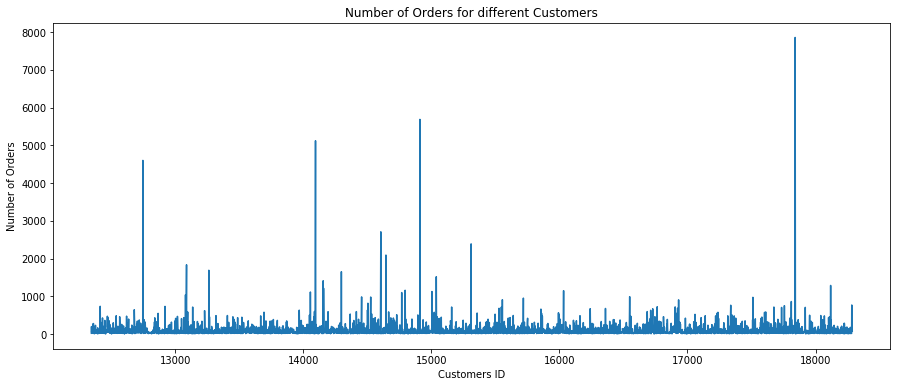

In [18]:
orders=df_new.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()
plt.subplots(figsize=(15,6))
plt.plot(orders.CustomerID, orders.InvoiceNo)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

In [19]:
orders.sort_values('InvoiceNo',ascending=False).head(10) #top 10 frequent customers

,CustomerID,Country,InvoiceNo
4050,17841,United Kingdom,7859
1903,14911,EIRE,5688
1308,14096,United Kingdom,5122
338,12748,United Kingdom,4601
1682,14606,United Kingdom,2709
2200,15311,United Kingdom,2389
1711,14646,Netherlands,2093
576,13089,United Kingdom,1835
706,13263,United Kingdom,1690
1455,14298,United Kingdom,1651


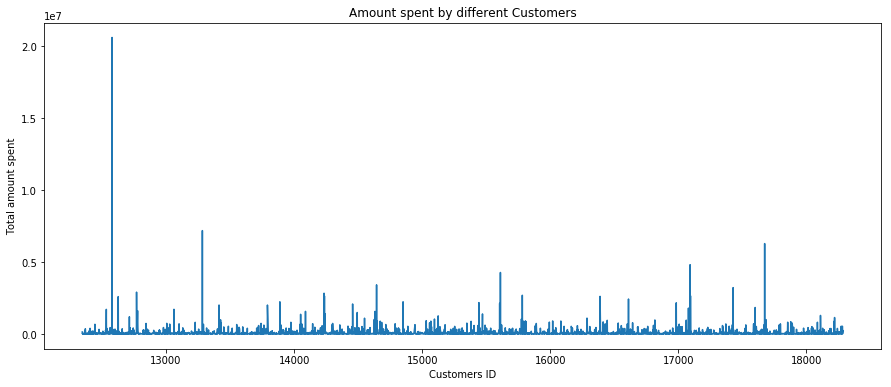

In [20]:
# amount spent by customers

amount=df_new.groupby(by=['CustomerID','Country'], as_index=False)['amount_spent'].sum()
plt.subplots(figsize=(15,6))
plt.plot(amount.CustomerID, amount.amount_spent)
plt.xlabel('Customers ID')
plt.ylabel('Total amount spent')
plt.title('Amount spent by different Customers')
plt.show()

In [21]:
amount.sort_values('amount_spent',ascending=False).head(10) #top 10 valuable customers

,CustomerID,Country,amount_spent
195,12579,France,20598464
723,13284,United Kingdom,7181463
3932,17674,United Kingdom,6279858
3515,17092,United Kingdom,4812019
2426,15611,United Kingdom,4272079
1709,14644,United Kingdom,3412986
3749,17428,United Kingdom,3220522
354,12770,Japan,2906225
1410,14234,United Kingdom,2830796
2553,15782,United Kingdom,2690377


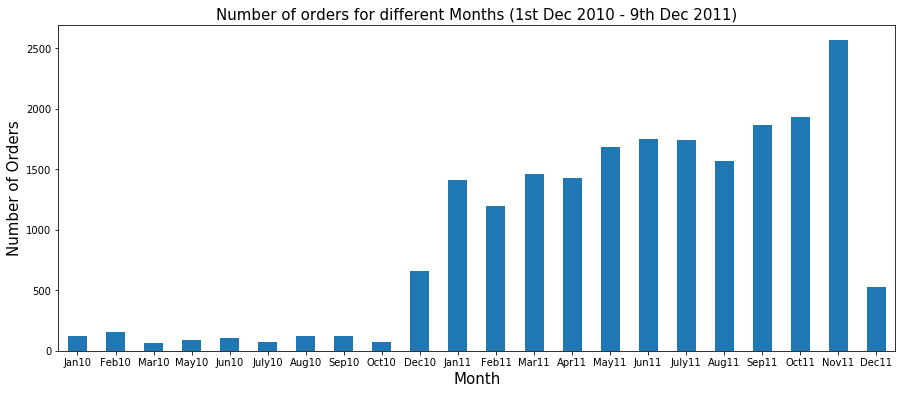

In [22]:
#frequency of purchases by timestamps

ax = df_new.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot('bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Jan10','Feb10','Mar10','May10','Jun10','July10','Aug10','Sep10','Oct10','Dec10','Jan11','Feb11','Mar11','Apr11','May11','Jun11','July11','Aug11','Sep11','Oct11','Nov11','Dec11'), rotation='horizontal', fontsize=10)
plt.show()

In [23]:
df_new.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index()

[201001]     124
[201002]     154
[201003]      61
[201005]      89
[201006]     104
[201007]      75
[201008]     121
[201009]     125
[201010]      75
[201012]     657
[201101]    1409
[201102]    1194
[201103]    1459
[201104]    1427
[201105]    1683
[201106]    1754
[201107]    1738
[201108]    1567
[201109]    1870
[201110]    1932
[201111]    2567
[201112]     524
Name: year_month, dtype: int64

In [24]:
df_new.groupby('InvoiceNo')['month'].unique().value_counts().sort_index() #november is highest sales month

[1]     1533
[2]     1348
[3]     1520
[4]     1427
[5]     1772
[6]     1858
[7]     1813
[8]     1688
[9]     1995
[10]    2007
[11]    2567
[12]    1181
Name: month, dtype: int64

In [25]:
df_new.groupby('InvoiceNo')['day'].unique().value_counts().sort_index() #thursday is highest sales day

[1]    3096
[2]    3515
[3]    3182
[4]    3953
[5]    3117
[6]    1174
[7]    2672
Name: day, dtype: int64

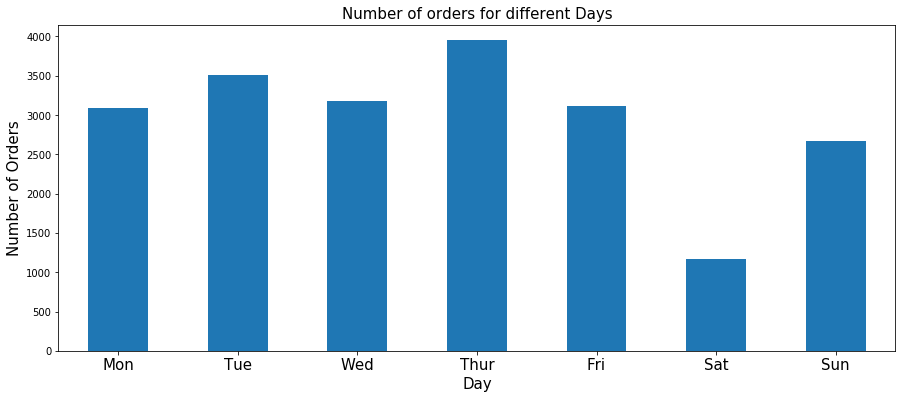

In [26]:
ax = df_new.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot('bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sat','Sun'), rotation='horizontal', fontsize=15)
plt.show()

In [27]:
df_new.groupby('year_month')['amount_spent'].sum() #earned largest at november'11

year_month
201001     5315098
201002     2123358
201003      619628
201005      844881
201006     7377428
201007      886313
201008     1809746
201009     3191953
201010     1104301
201012     9690328
201101    28006619
201102    19751686
201103    22474557
201104    25710306
201105    28870735
201106    27697720
201107    23758509
201108    32281682
201109    52334151
201110    44885898
201111    46130442
201112     5633376
Name: amount_spent, dtype: int64

In [28]:
df_new.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index() #12:00 pm is the peak time

[6]       13
[7]       29
[8]      592
[9]     1532
[10]    2466
[11]    2552
[12]    3384
[13]    2877
[14]    2484
[15]    2272
[16]    1350
[17]     723
[18]     220
[19]     189
[20]      25
Name: hour, dtype: int64

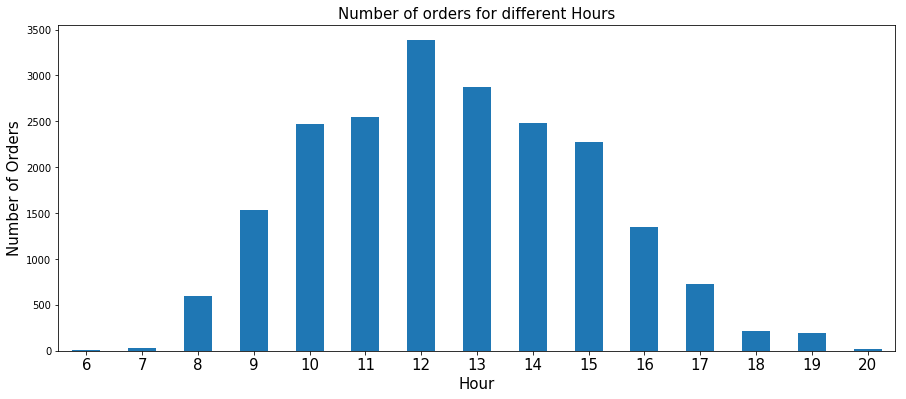

In [29]:
ax = df_new.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index().plot('bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

In [30]:
df_new.UnitPrice.describe()

count    446933.000000
mean         81.130066
std        1295.854385
min           0.000000
25%           1.250000
50%           2.080000
75%           4.950000
max      162825.000000
Name: UnitPrice, dtype: float64

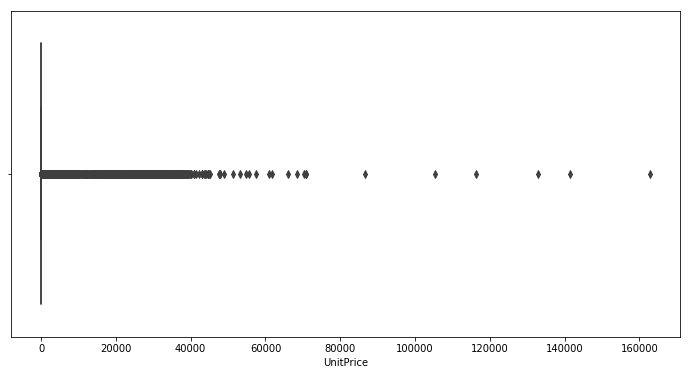

In [31]:
plt.subplots(figsize=(12,6))
sns.boxplot(df_new.UnitPrice)
plt.show() 

#shows how the unit price of items are scattered in the dataset
#most of the items are in the range of 0-40k

In [32]:
df_free = df_new[df_new.UnitPrice == 0]
df_free.head()

#free items analysis

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent
9302,537197,22841,201005,5,3,14,ROUND CAKE TIN VINTAGE GREEN,1,2010-05-12 14:02:00,0.0,12647,Germany,0
33576,539263,22580,201012,12,4,14,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom,0
40089,539722,22423,201012,12,2,13,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE,0
47068,540372,22090,201106,6,3,16,PAPER BUNTING RETROSPOT,24,2011-06-01 16:41:00,0.0,13081,United Kingdom,0
47070,540372,22553,201106,6,3,16,PLASTERS IN TIN SKULLS,24,2011-06-01 16:41:00,0.0,13081,United Kingdom,0


In [33]:
df_free.year_month.value_counts().sort_index()

201005     2
201012     3
201101     2
201102     2
201103     7
201104     6
201105     4
201106     4
201107     7
201108    10
201109     4
201110     6
201111    12
201112     1
Name: year_month, dtype: int64

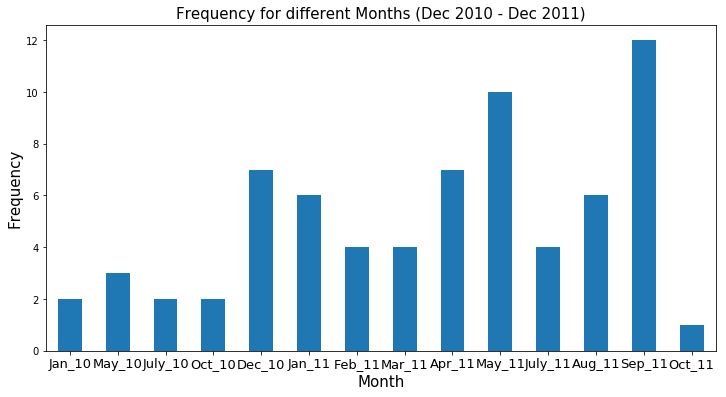

In [34]:
ax = df_free.year_month.value_counts().sort_index().plot('bar',figsize=(12,6), color=color[0])
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Jan_10','May_10','July_10','Oct_10','Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.show()

#sept '11 had largest no. of free items sold

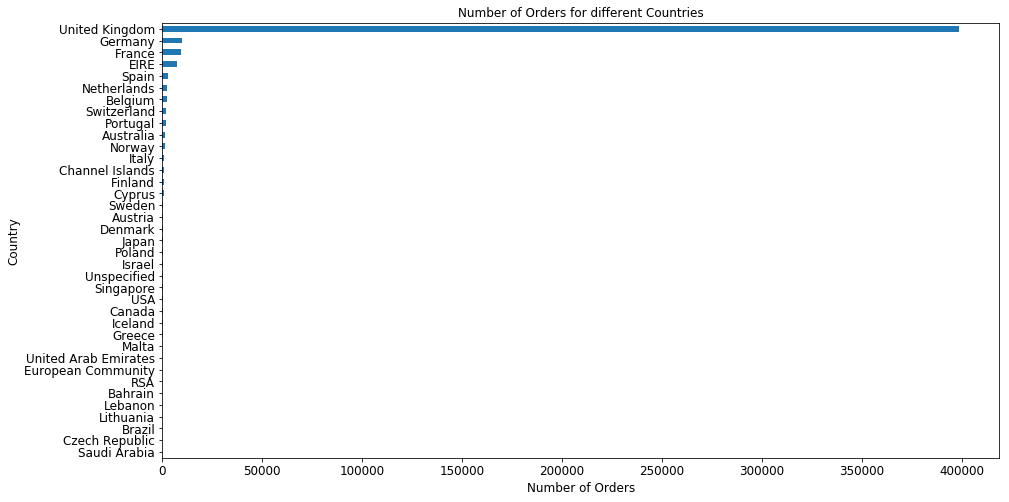

In [35]:
#frequency purchases by countries

group_country_orders = df_new.groupby('Country')['InvoiceNo'].count().sort_values()

plt.subplots(figsize=(15,8))
group_country_orders.plot('barh', fontsize=12, color=color[0])
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

#UK people made largest no. of orders

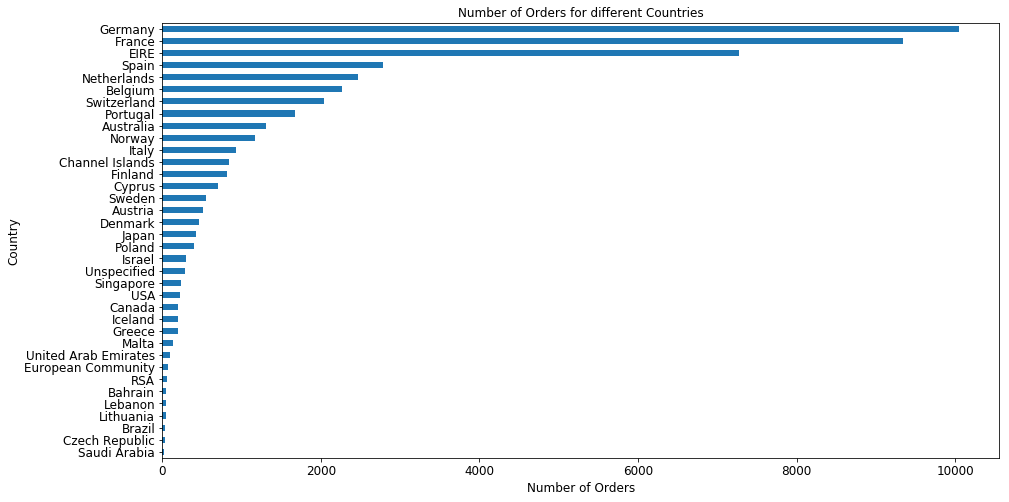

In [36]:
#except UK 
group_country_orders = df_new.groupby('Country')['InvoiceNo'].count().sort_values()
del group_country_orders['United Kingdom']

plt.subplots(figsize=(15,8))
group_country_orders.plot('barh', fontsize=12, color=color[0])
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

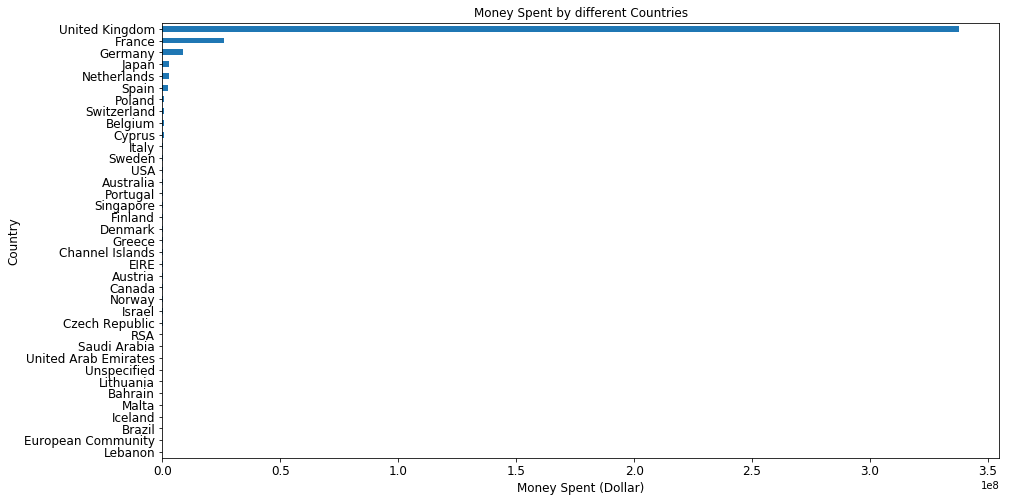

In [37]:
# amount spent by countries
group_country_amount_spent = df_new.groupby('Country')['amount_spent'].sum().sort_values()
# del group_country_orders['United Kingdom']

# plot number of unique customers in each country (with UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot('barh', fontsize=12, color=color[0])
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

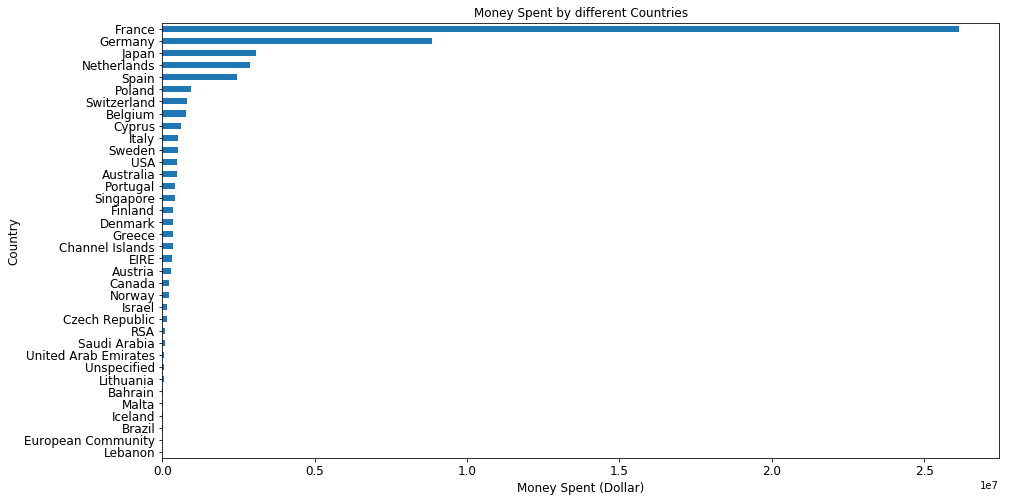

In [38]:
group_country_amount_spent = df_new.groupby('Country')['amount_spent'].sum().sort_values()
del group_country_amount_spent['United Kingdom']

# plot number of unique customers in each country (without UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot('barh', fontsize=12, color=color[0])
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

#though germany has more no.of orders, france people bought costlier items

# Predictive analysis

1. Before Customer clustering, products must be clustered into different segments
2. For Products clustering NLP techniques are used on Product description

In [39]:
import nltk

In [40]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [41]:
df_products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})

In [42]:
df_products.head()

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


In [43]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Nb of keywords in variable 'Description': 21368


In [44]:
keywords

['heart',
 'holder',
 'metal',
 'lantern',
 'cream',
 'cupid',
 'coat',
 'hanger',
 'union',
 'flag',
 'water',
 'bottle',
 'nest',
 'box',
 'glass',
 'star',
 'hand',
 'jack',
 'warmer',
 'dot',
 'bird',
 'ornament',
 'poppy',
 'playhouse',
 'bedroom',
 'kitchen',
 'feltcraft',
 'princess',
 'charlotte',
 'doll',
 'ivory',
 'cosy',
 'colour',
 'teaspoons',
 'vintage',
 'jigsaw',
 'block',
 'alphabet',
 'home',
 'build',
 'word',
 'love',
 'recipe',
 'england',
 'jam',
 'jar',
 'rack',
 'pari',
 'fashion',
 'bath',
 'alarm',
 'clock',
 'bakelike',
 'pink',
 'green',
 'panda',
 'bunny',
 'sheet',
 'tape',
 'globe',
 'head',
 'tail',
 'game',
 'set/2',
 'retrospot',
 'tea',
 'towel',
 'round',
 'snack',
 'woodland',
 'spaceboy',
 'lunch',
 'i',
 'london',
 'circus',
 'bag',
 'design',
 'toadstool',
 'night',
 'light',
 'seaside',
 'puzzle',
 'mini',
 'parad',
 'paint',
 'postage',
 'paper',
 'chain',
 'christmas',
 'parasol',
 'coffee',
 'mug',
 'planet',
 'billboard',
 'love/hate',
 'wo

In [45]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

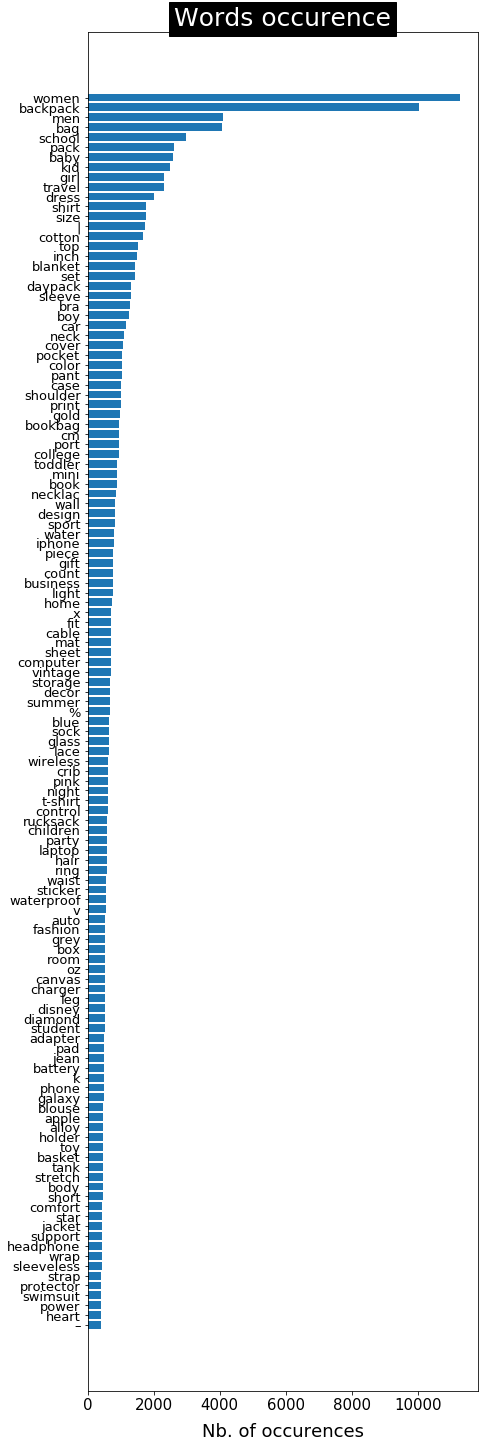

In [46]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [50]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['men','women','pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 30: continue
    if ('+' in word) or ('/' in word) or ('%' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('length of conserved products:', len(list_products))

length of conserved products: 1353


In [52]:
list_products1 = df['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_products1))

In [55]:
X.head()

,backpack,bag,school,pack,baby,kid,girl,travel,dress,shirt,...,pom,stroller,multi-pocket,bradley,lego,stranger,transit,safari,abstract,autocare
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
matrix = X.as_matrix()
# taking 5 clusters
nc=5
kmeans = KMeans(init='k-means++', n_clusters = nc, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)
# silhouette_avg = silhouette_score(matrix, clusters)
# print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

In [63]:
pd.Series(clusters).value_counts()

1    44531
3     1783
0      481
2      427
4      110
dtype: int64

In [65]:
#determining most frequent keyword in each of the cluster
nc=5
liste = pd.DataFrame(list_products1)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(nc)]

for i in range(nc):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

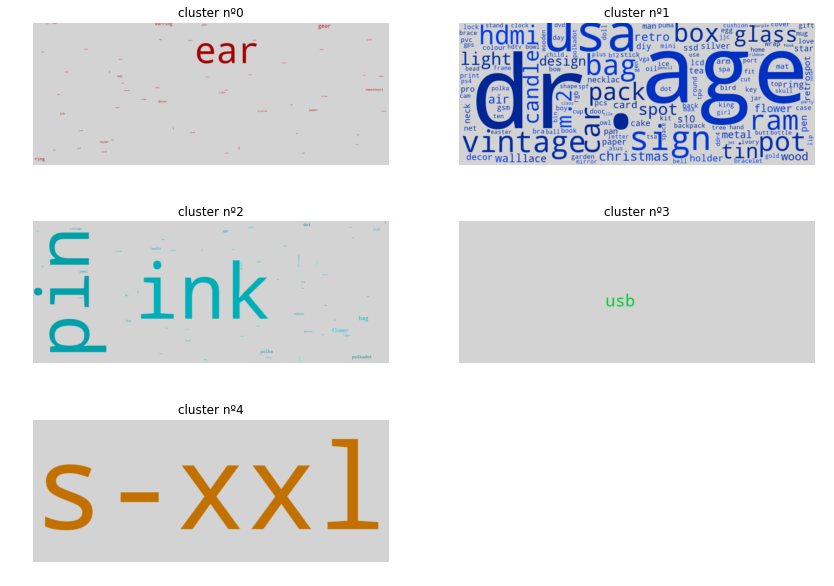

In [71]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(nc):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

# Now Clustering customers based on the product buying patterns

In [72]:
corresp = dict()
for key, val in zip (list_products1, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_new['categ_product'] = df_new.loc[:, 'Description'].map(corresp)


In [74]:
df_new.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent,categ_product
0,536365,85123A,201001,1,2,8,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15,0
1,536365,71053,201001,1,2,8,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20,1
2,536365,84406B,201001,1,2,8,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22,0
3,536365,84029G,201001,1,2,8,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20,1
4,536365,84029E,201001,1,2,8,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20,0


In [75]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_new[df_new['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_new.loc[:, col] = price_temp
    df_new[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_new[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.30,0.00,0.0,0.0,0.0
1,536365,WHITE METAL LANTERN,1,0.00,20.34,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.00,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.00,20.34,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34,0.00,0.0,0.0,0.0


In [76]:
temp = df_new.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['amount_spent'].sum()
basket_price = temp.rename(columns = {'amount_spent':'Basket Price'})
#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_new.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# date de la commande
df_new['InvoiceDate_int'] = df_new['InvoiceDate'].astype('int64')
temp = df_new.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_new.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12346,541431,91572,0.00,90924.60,0.0,648.0,0.0,2011-01-18 10:01:00.000000000
1,12346,C541433,47751,0.00,47718.00,0.0,33.0,0.0,2011-01-18 10:17:00.000000000
2,12347,537626,953,123.54,786.75,52.5,0.0,0.0,2010-07-12 14:57:00.000001024
3,12347,542237,514,28.44,459.55,35.4,0.0,0.0,2011-01-26 14:29:59.999999744
4,12347,549222,723,30.00,688.55,11.7,0.0,0.0,2011-07-04 10:42:59.999999232


In [77]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-01-12 08:26:00 -> 2011-12-10 17:18:59.999999488


In [81]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

AttributeError: 'Series' object has no attribute 'date'

In [82]:
basket_price['InvoiceDate']

0       2011-01-18 10:01:00.000000000
1       2011-01-18 10:17:00.000000000
2       2010-07-12 14:57:00.000001024
3       2011-01-26 14:29:59.999999744
4       2011-07-04 10:42:59.999999232
5       2011-09-06 13:01:00.000000512
6       2011-02-08 08:48:00.000000000
7       2011-10-31 12:25:00.000001280
8       2011-07-12 15:52:00.000000000
9       2010-12-16 19:09:00.000000512
10      2011-01-25 10:42:00.000000000
11      2011-05-04 10:47:00.000000000
12      2011-09-25 13:13:00.000000000
13      2011-11-21 09:51:00.000000768
14      2011-02-02 16:01:00.000000768
15      2011-02-16 12:32:59.999999744
16      2011-01-03 14:57:00.000000000
17      2011-01-03 15:52:00.000000000
18      2011-03-17 16:00:00.000000000
19      2011-03-22 16:08:00.000000000
20      2011-09-20 14:34:00.000000000
21      2011-09-28 14:58:00.000000000
22      2011-03-11 14:37:00.000000000
23      2011-01-03 15:47:00.000000000
24      2011-01-03 15:49:00.000000000
25      2011-03-22 16:07:00.000000000
26      2011